# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2017

#### Número de grupo: 13
#### Integrantes:
- Giovani Rondán, CI: 4.528.997-6
- Santiago Behak, CI: 5.019.450-0

## 1- Importación de los tweets.

Comenzaremos importando los tweets provenientes del archivo "corpus_humor_training.csv" usando la librería Pandas:

In [45]:
import pandas
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
import re
#import freeling
from pylab import *
import numpy as np
from nltk.corpus import stopwords
import IPython.display as disp
import os

corpus = pandas.read_csv("corpus_humor_training.csv",encoding='utf-8')

Los registros de este corpus están compuestos por varios datos además del propio texto del tweet. A continuación mostraremos la estructura del corpus y algunos de los tweets (que se encuentran en el atributo "text") a modo de ejemplo:

In [46]:
print(corpus.columns)
print ("\n")
for text in corpus['text'][:7]:
    print(text + '\n')

Index(['id', 'text', 'account_id', 'n', '1', '2', '3', '4', '5'], dtype='object')


-La semana pasada mi hijo hizo un triple salto mortal desde 20 metros de altura - ¿Es trapecista? -Era :(

-Yo ya voy por mi segundo millón de dólares... -¿!Ah, si!? -Es que el primero nunca lo hice... #fb

-Ayer fue mi cumpleaños y no me felicitaste - ¡FéÉLíCÍDáÁDÉéS! - ¿Qué haces? -Felicitarte con retraso.

No es flojera, es un estado de ahorro de energía corporal :)

- ¿Cómo te fue en matemática? -Vos sabes que soy muy pacífica - ¿Y eso qué tiene que ver? -No me gustan los problemas jajaja -Castigada - :(

"El pesimista se queja del viento; el optimista espera que cambie; el realista ajusta las velas" Feliz miércoles.

-¿Y tú desde cuando llevas pendiente? 
-Desde que mi mujer se lo encontró en el coche y le dije que era mío...



A continuación porocedemos a analizar las características del corpus obtenido, para esto obtendremos algunos datos básicos tales como la cantidad total de tweets, la cantidad de atributos de los que disponemos, la cantidad de calificaciones de los 10 tweets más calificados y la cantidad total de calificaciones.

In [47]:
cantTweets = len(corpus)
cantAtributos = len(corpus.columns)

# Imprimimos la cantidad total de tweets y la cantidad de atributos
print ("Cantidad de Tweets en el corpus: " + str(cantTweets))
print ("Cantidad de atributos en el corpus: " + str(cantAtributos))

# Imprimimos la cantidad de calificaciones de los 10 tweets mas calificados y la cantidad total de calificaciones
totalCalificaciones = 0
contador = 0
corpus["cantCalificaciones"] = [0]*len(corpus)
for i in range(0, 12106):
    calificacionesTweet =corpus.loc[i, "n"] + corpus.loc[i, "1"]  + corpus.loc[i, "2"] + corpus.loc[i, "3"] + corpus.loc[i, "4"] + corpus.loc[i, "5"]
    totalCalificaciones += calificacionesTweet
    corpus.loc[i, "cantCalificaciones"] = calificacionesTweet

print ("Lista de los diez tweets con más calificaciones:\n")
disp.display(corpus.sort_values(by = ['cantCalificaciones'], ascending = False).head(10))

Cantidad de Tweets en el corpus: 12106
Cantidad de atributos en el corpus: 9
Lista de los diez tweets con más calificaciones:



,id,text,account_id,n,1,2,3,4,5,cantCalificaciones
5879,445969156437852161,"—¿A dónde vas tan maquillada? —A una fiesta, m...",1518218509,2,6,3,2,6,2,21
8158,446273545304162304,"JAJAJAJAJAJA ¿TE ACUERDAS CUANDO... ah, no, tú...",229144847,13,2,1,4,0,0,20
10238,446423336831053824,"""Tu invades mi cabeza"" —Juanita, 10 años, tien...",229144847,4,6,4,3,2,0,19
11728,464188098780618752,#Chistetipico,124053720,17,0,0,0,1,0,18
7849,447042317480763393,"""Es imposible"" dijo el orgullo; ""es arriesgado...",1518218509,6,6,1,1,3,0,17
8966,448704341365366784,-Tenemos una relación seria. -¿Lleváis mucho t...,1518218509,1,2,4,3,3,4,17
1117,446934186889211905,"Hablo 3 idiomas: español, sarcasmos e indirectas.",1518218509,6,4,1,4,0,1,16
7037,445481775133777921,Molestar a alguien solo porque te gusta ver co...,1518218509,14,1,0,1,0,0,16
9273,445669834211069952,A mi también me castigaron por reírme mientras...,1518218509,11,3,0,0,2,0,16
4306,447613590992732160,"—En mis tiempos... —Sí, sí abuela, como digas,...",1518218509,4,1,3,4,2,1,15


Otro dato que puede resultar interesante es la cantidad de calificaciones por valor (las calificaciones no humorísiticas serán contadas con el 0).

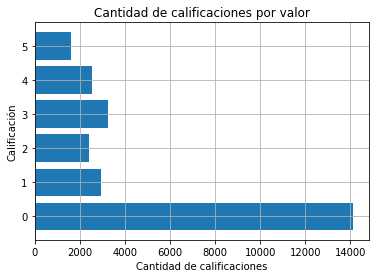

In [48]:
%matplotlib inline

# Se realiza una gráfica de cantidad de comentarios en función de su clasificación
calificacionesPorValor = [corpus["n"].sum(), corpus["1"].sum(), corpus["2"].sum(), corpus["3"].sum(), corpus["4"].sum(), corpus["5"].sum()]
valoresCalificaciones = ["0", "1", "2", "3", "4", "5"]
pos = arange(len(valoresCalificaciones)) + 0.5 

figure(1)
barh(pos,calificacionesPorValor, align='center')
yticks(pos, valoresCalificaciones)
xlabel('Cantidad de calificaciones')
ylabel(u'Calificación')
title(u'Cantidad de calificaciones por valor')
grid(True)
show()

Como se puede ver en la gráfica la mayoría de las calificaciones corresponden al valor 0, o sea, como calificaciones no humorísticas.

## 2- Preprocesmiento de los datos

En primer lugar procederemos a eleminar las columnas del corpus que consideramos innecesarias. Eliminaremos la columna de la id del tweet ya que este es un número autogenerado aleatorio que no debería aportar información relevante.

In [49]:
if "id" in corpus.columns:
    del corpus["id"]
print (corpus.columns)


Index(['text', 'account_id', 'n', '1', '2', '3', '4', '5',
       'cantCalificaciones'],
      dtype='object')


Una vez filtradas las columnas del corpus nos disponemos a filtrar los tweets que tienen menos de tres calificaciones dado que los mismos no cuentan con una cantidad significativa de calificaciones como para ser evaluados. Además se eliminarán los hashtags de los textos de los tweets como se pide en la letra y agregaremos una nueva columna que determina si un tweet es humorístico en función del número de calificaciones no humorísticas en relación al total de calificaciones del tweet. Si la cantidad de calificaciones humorísticas es mayor o igual a la suma del resto de calificaciones el tweet se considerará no humorístico.

In [50]:
corpus["humoristico"] = [False]*len(corpus)
corpus_filtrado = pandas.DataFrame(columns = ['text', 'n', '1', '2', '3', '4', '5', 'humoristico', 'cantCalificaciones'])
#corpus_filtrado = corpus[corpus.n + corpus.columns[4] + corpus.columns[5] + corpus.columns[6] + corpus.columns[7] + corpus.columns[8] >= 3]
total = 0
for i in range(0, 12106):
    contador = corpus.loc[i, "cantCalificaciones"]
    #eliminamos los hashtags
    corpus.loc[i, "text"] = re.sub(r"#\S+\s*", "", corpus.loc[i, "text"])
    #definimos si un tweet es humoristico o no segun los votos
    if(contador/2 >= corpus.loc[i, "n"]):
        corpus.loc[i, "humoristico"] = True
    #filtramos los tweets que tienen menos de 3 votos
    if contador >= 3:
        corpus_filtrado.loc[total] = [corpus.loc[i, "text"], corpus.loc[i, "n"], corpus.loc[i, "1"], corpus.loc[i, "2"], corpus.loc[i, "3"], corpus.loc[i, "4"], corpus.loc[i, "5"], corpus.loc[i, "humoristico"], corpus.loc[i, "cantCalificaciones"]]
        total += 1
        
#columna 3 -> n, 4 -> 1, 5 -> 2, 6 -> 3, 7 -> 4, 8 -> 5

disp.display(corpus_filtrado.loc[0:10, :])
print ("Cantidad de tweets que quedan en el corpus luego del filtrado: " + str(len(corpus_filtrado)))

,text,n,1,2,3,4,5,humoristico,cantCalificaciones
0,-La semana pasada mi hijo hizo un triple salto...,0,1,1,0,0,1,True,3
1,-Yo ya voy por mi segundo millón de dólares......,2,1,0,0,0,0,False,3
2,-Ayer fue mi cumpleaños y no me felicitaste - ...,0,1,1,1,0,1,True,4
3,"No es flojera, es un estado de ahorro de energ...",1,1,1,0,0,0,True,3
4,- ¿Cómo te fue en matemática? -Vos sabes que s...,2,0,0,1,0,0,False,3
5,"-Compadre, su hija antes me daba como por las ...",1,1,0,0,1,0,True,3
6,Había una vez una tortuguita que fue a su prim...,1,2,1,0,0,0,True,4
7,"Una novia que sea tan delicada como Neymar, es...",2,0,0,0,1,0,False,3
8,¿Qué le dice el Nesquik a la leche? ¡Te voy a ...,2,1,0,0,1,0,True,4
9,Si oscar se queda me pego un tiro con un banan...,6,1,1,0,1,0,False,9


Cantidad de tweets que quedan en el corpus luego del filtrado: 3438


## 3- Separación de los datos en conjunto de train y test

A continuación dividiremos el corpus restante en un conjunto de train y en otro de test. En principio usaremos un 80% de los datos para el entrenamiento y un 20% para el testeo.

In [55]:
corpus_train, corpus_test = train_test_split(corpus_filtrado, test_size=0.2)

print ("Cantidad de tweets en el conjunto de entrenamiento: " + str(len(corpus_train)))
print ("Cantidad de tweets en el conjunto de testeo: " + str(len(corpus_test)))

Cantidad de tweets en el conjunto de entrenamiento: 2750
Cantidad de tweets en el conjunto de testeo: 688


## 4- Clasificador binario con tokenizador y POS tag de Freeling

Una vez separados el conjunto de train y test procedemos a tokenizar los tweets provenientes del conjunto train. Para esto usaremos la librería Freeling y NLTK. Primero definiremos una función que tokeniza un corpus usando freeling y a la que se le pueden pasar filtros para eliminar palabras basados en el postag:

In [59]:
from subprocess import Popen, PIPE, STDOUT
import datetime
import traceback as tb

def filtrar_corpus(corpus, largo_corpus, filtros, train, lemma = True, usuario = False):
    result = []
    palabras = ""
    finTweet = "13grupoPLN"
    cualquiera = 0
    cualquiera2 = 0
    for i in range(0,largo_corpus):
        try:
            palabras+= corpus.loc[i, "text"]
            palabras+= ". "
            palabras+= finTweet
            palabras+= ". "
            cualquiera += 1
        except:
            cualquiera2 += 1
            pass

    # Por cada palabra retornada de la tokenizacion del comentario
    p = Popen("C:/Users/Usuario/Desktop/PLN2017/FreelingWindows/bin/analyzer.bat -f C:/Users/Usuario/Desktop/PLN2017/FreelingWindows/data/config/es.cfg", shell = True, stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    stdout = p.communicate(input=palabras.encode())[0]
    iterator = 0
    tweets = stdout.decode().split('\r\n')
    contador = 0
    for palabra in tweets:
        spliteado = palabra.split(' ')
        if(spliteado[0] == finTweet):
            contador += 1
    for i in range(0,largo_corpus):
        try:
            esHumoristico = corpus.loc[i,"humoristico"]
            error = False
        except:
            error = True
        if (not error):
            tokens = tweets[iterator].split(' ')
            iterator += 1
            diccionario = {}
            while (tokens[0] != finTweet):
                if(tokens[0] != ''):
                    if(lemma):
                        token = tokens[1]
                    else:
                        token = tokens[0]
                    tag = tokens[2]
                    flag = True
                    for filtro in filtros:
                        tag_aux = tag[0:len(filtro)]
                        if (tag_aux == filtro):
                            flag = False
                            break
                    if flag:
                        if(token in diccionario):
                            diccionario[token] = diccionario[token] + 1
                        else:
                            diccionario[token] = 1
                tokens = tweets[iterator].split(' ')
                iterator += 1
            if(usuario):
                diccionario[str(corpus.loc[i,"account_id"])] = 1
            if(train):
                result.append((diccionario,corpus.loc[i,"humoristico"]))
            else:
                result.append(diccionario)
    return result

#def agregar_tweet_diccionario(diccionario,tweet):



Con esta función probaremos dos clasificadores (Naive Bayes y Máxima Entropía). Los filtros que consideramos usar son: "F" (signos de puntuacion), "D" (determinantes), "P" (pronombres), "S" (aposiciones) y "Z" (números). Además, en esta función vectorizamos los lemas de las palabras en lugar de su forma, de esta forma agrupamos palabras que en definitiva tienen el mismo significado. Probaremos usar todas las combinaciones de clasificadores y filtros y veremos cuales dan mejores resultados.

In [37]:
import nltk
from nltk.metrics.scores import *
import itertools

max_accuracy = 0
filtros = ["F", "D", "P", "S", "Z"]
for i in range(1, len(filtros) + 1):
    filter_combinations = itertools.combinations(filtros, i)
    for filter_combination in filter_combinations:
        corpus_pos_tagging = filtrar_corpus(corpus_train, len(corpus_filtrado), filter_combination, True)
        classifiers = []
        classifiers += [[nltk.classify.NaiveBayesClassifier.train(corpus_pos_tagging), "Naive Bayes"]]
        classifiers += [[nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0), "Maxima Entropia"]]

        print("entrene")
        #for classifier in classifiers:
        #    classifier[0].show_most_informative_features()
        salida = []
        corpus_test_tokenizado = filtrar_corpus(corpus_test, len(corpus_filtrado), filter_combination, False)
        for classifier in classifiers:
            salidaClasificador = []
            for tweet in corpus_test_tokenizado:
                # Se obtiene la clasificacion del algoritmo para el comentario
                try:
                    clasificacion = classifier[0].classify(tweet)
                    salidaClasificador.append(clasificacion)
                except:
                    pass

            salida = corpus_test.loc[:, "humoristico"]
            cm = nltk.ConfusionMatrix(salidaClasificador, salida)
            print("Matriz de confusión de " + classifier[1] + " con filtros: " + '-'.join(filter_combination))
            print(cm)
            acc = accuracy(salidaClasificador, salida)
            print("Accuracy: " + str(acc))
            if acc > max_accuracy:
                max_accuracy = acc
                best_combination = filter_combination
                
print("Mejor combinacion: " + '-'.join(best_combination))

2750
688
2750
entrene
688
2750
688
Matriz de confusión de Naive Bayes con filtros: F
  |   0   1   2 |
--+-------------+
0 |<124>130   . |
1 | 194<240>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5290697674418605
Matriz de confusión de Maxima Entropia con filtros: F
  |   0   1   2 |
--+-------------+
0 |<149>152   . |
1 | 169<218>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5334302325581395
2750
688
2750
entrene
688
2750
688
Matriz de confusión de Naive Bayes con filtros: D
  |   0   1   2 |
--+-------------+
0 |<113>120   . |
1 | 205<250>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5276162790697675
Matriz de confusión de Maxima Entropia con filtros: D
  |   0   1   2 |
--+-------------+
0 |<154>156   . |
1 | 164<214>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5348837209302325
2750
688
2750
entrene
688
2750
688
Matriz de confu

2750
entrene
688
2750
688
Matriz de confusión de Naive Bayes con filtros: F-P-S
  |   0   1   2 |
--+-------------+
0 |<131>132   . |
1 | 187<238>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5363372093023255
Matriz de confusión de Maxima Entropia con filtros: F-P-S
  |   0   1   2 |
--+-------------+
0 |<145>153   . |
1 | 173<217>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5261627906976745
2750
688
2750
entrene
688
2750
688
Matriz de confusión de Naive Bayes con filtros: F-P-Z
  |   0   1   2 |
--+-------------+
0 |<132>135   . |
1 | 186<235>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5334302325581395
Matriz de confusión de Maxima Entropia con filtros: F-P-Z
  |   0   1   2 |
--+-------------+
0 |<139>155   . |
1 | 179<215>  . |
2 |   .   .  <.>|
--+-------------+
(row = reference; col = test)

Accuracy: 0.5145348837209303
2750
688
2750
entrene
688
2750
688
Matriz d

Como se puede ver los mejores resultados se dan con Maxima Entropia cuando solo se tiene el filtro "Z" de los números con 55% de precisión. De todas formas los resultados no son muy buenos y no parecen variar mucho en función de los filtros usados (todos los resultados varían en el entorno del 51% y 55% de precisión). En función de estos resultados mantendremos el clasificador de maxima entropia y el filtro para los números pero agregaremos más features para intentar mejorar los resultados.
Una primera mejora que podemos hacer es registrar la forma de las palabras en lugar de su lema como estábamos haciendo hasta ahora. Estos son los resultados:

In [ ]:
corpus_pos_tagging = filtrar_corpus(corpus_train, len(corpus_filtrado), ["Z"], True, True, False)
clf = nltk.classify.MaxentClassifier.train(corpus_pos_tagging, max_iter=8,trace=0)
corpus_test_tokenizado = filtrar_corpus(corpus_test, len(corpus_filtrado), ["Z"], False, True, False)
salidaClasificador = []
salida = []
for tweet in corpus_test_tokenizado:
    # Se obtiene la clasificacion del algoritmo para el comentario
    try:
        clasificacion = classifier[0].classify(tweet)
        salidaClasificador.append(clasificacion)
    except:
        pass

salida = corpus_test.loc[:, "humoristico"]
cm = nltk.ConfusionMatrix(salidaClasificador, salida)
print("Matriz de confusión de " + classifier[1] + " con filtros: Z")
print(cm)
acc = accuracy(salidaClasificador, salida)
print("Accuracy: " + str(acc))



### 4.1- Tokenización